# Introduzione

Questo Notebook consente di creare facilmente un report grafico di dettaglio di analisi tecnica.

Di seguito le fonti che mi sono state utili per realizzare questo Notebook e che vi invito ad approfondire:

1. [Articolo di Gianluca Malato](https://towardsdatascience.com/detection-of-price-support-and-resistance-levels-in-python-baedc44c34c9): per disegnare i supporti e le resistenze
2. [Articolo di Gregory Morse](https://towardsdatascience.com/detection-of-price-support-and-resistance-levels-in-python-baedc44c34c9): per capire come utilizzare la libreria **trendln**

# 1. Installazione e import delle librerie

In [ ]:
!pip install mplfinance
!pip install trendln --upgrade --no-cache-dir
!pip install yfinance
!pip install pandas
!pip install numpy
!pip install ta
!pip install matplotlib
!pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import datetime as dt
from ta import add_all_ta_features
from ta.utils import dropna
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.gridspec as gs
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import trendln
sns.set()
%matplotlib inline

# Definizione dei parametri

Tutti i paramentri di configurazione sono indicati dalla cella sottostante.
1. Va indicato il **ticker** dell'asset che si vuole analizzare. **NB** Dev'essere compatibile con Yahoo Finance
2. Definire l'intervallo di date per il quale si desiderano scaricare i dati
3. Definire l'intervallo di date per il quale di desidera visualizzare il report

In [7]:
asset = "CANG"
# Valori utilizzati per il download del titolo. NB: I supporti e le resistenze vengono rilevati da questo intervallo
start = dt.date(2018, 10, 1)
end = dt.date.today()
# Valori utilizzati per la visualizzazione su grafico
start_date_plot = dt.date(2020, 10, 1)
end_date_plot = dt.date.today()

### Download e manipolazione dati

In [8]:
downloaded_data = yf.download(asset, start=start, end=end)

df = downloaded_data.copy()
df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df['Ma21'] = df['Close'].rolling(21).mean()
df['Ma50'] = df['Close'].rolling(50).mean()
df['Ma200'] = df['Close'].rolling(200).mean()
df['Volume_mean'] = df['Volume'].rolling(30).mean()

df.dropna(inplace=True)

df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume")

print("Elenco degli indicatori implementati da TA")
print(df.columns)

[*********************100%***********************]  1 of 1 completed
Elenco degli indicatori implementati da TA
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ma21', 'Ma50',
       'Ma200', 'Volume_mean', 'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_

/usr/local/lib/python3.7/site-packages/ta/trend.py:643: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.7/site-packages/ta/trend.py:647: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


### Definizione Funzioni

In [9]:
def isSupport(df,i):
    support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] \
        and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]

    return support

def isResistance(df,i):
    resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] \
        and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2] 

    return resistance

def isFarFromLevel(l):
    return np.sum([abs(l-x) < s  for x in levels]) == 0

def get_coordinates(tup, time_series):
    
    points = tup[0]
    values = tup[1]
    
    x=[]
    y=[]
    for i in points:
        x.append(time_series.index[i])
        y.append(i*values[0]+values[1])
    return x, y
   
def get_coordinates_tuples(trend, time_series):
    buffer = []
    ris = []
    i = 0
    for t in trend:
        if i>=3:
            break
        x, y = get_coordinates(t, time_series)
        if isFarFromLine(np.sum(np.array(t[0])), buffer):
            ris.append((x, y))
            i = i+1
    return ris
        
def isFarFromLine(el, buffer):
    for i in buffer:
        if abs(el - i)/el * 100 < 15:
            return False
    buffer.append(el)
    return True
        
def plot_all():
    
    # Filtro i dati da visualizzare
    df_filtered = df[start_date_plot: end_date_plot].copy()
    ohlc = df_filtered[['Date', 'Open', 'High', 'Low', 'Close']].copy()

    fig = plt.figure(figsize=(25,20))
    gs = fig.add_gridspec(100, 1)
    
    fig.suptitle("{0} - da {1} a {2}".format(asset, start_date_plot, end_date_plot))
    fig.patch.set_facecolor('white')
    
    # Organizzo i subplot
    price_ax = fig.add_subplot(gs[0: 60, 0])
    volume_ax = fig.add_subplot(gs[65:73, 0])
    rsi_ax = fig.add_subplot(gs[77:87, 0])
    adx_ax = fig.add_subplot(gs[91:99, 0])
    
    # Imposto i titoli dei subplot
    price_ax.set_title('Candlestick plot')
    volume_ax.set_title('Volumi')
    rsi_ax.set_title('Rsi')
    adx_ax.set_title('Adx')
    
    
    # price_ax
    price_ax.set_xlabel('Date')
    price_ax.set_ylabel('Asset price')
    price_ax.set_facecolor((0.2,0.2,0.2))
    price_ax.yaxis.grid(False)
    price_ax.xaxis.grid(True)
    for axis in ['top','bottom','left','right']:
        price_ax.spines[axis].set_linewidth(0.5)
    
    candlestick_ohlc(price_ax, zip(mdates.date2num(ohlc.index.to_pydatetime()),
                     ohlc['Open'], ohlc['High'], ohlc['Low'], ohlc['Close']),
                     width=0.6, colorup='green', colordown='red', alpha=0.8)
    yLabels = []
    for level in levels:
        price_ax.axhline(level[1],xmin=0, xmax=1, linestyle='dotted', color = "turquoise", linewidth = 1)
        yLabels.append(round(level[1], 0))
    price_ax.set_yticks(np.array(yLabels))
    
    price_ax.plot(df_filtered['Ma21'], color = 'cyan', linewidth = 1.2, label="MA21 -> {0:.2f}".format(df_filtered['Ma21'].iloc[-1]))
    price_ax.plot(df_filtered['Ma50'], color = 'violet', linewidth = 1.2, label="MA50 -> {0:.2f}".format(df_filtered['Ma50'].iloc[-1]))
    price_ax.plot(df_filtered['Ma200'], color = 'crimson', linewidth = 1.2, label="MA200 -> {0:.2f}".format(df_filtered['Ma200'].iloc[-1]))
    price_ax.legend(loc='upper left')
    
    # Gestione delle trendline
    (minimaIdxs, pmin, mintrend, minwindows), (maximaIdxs, pmax, maxtrend, maxwindows) = trendln.calc_support_resistance(df_filtered['Close'], accuracy=8)
    
    mint = get_coordinates_tuples(mintrend, df_filtered['Close'])
    maxt = get_coordinates_tuples(maxtrend, df_filtered['Close'])
    for m in mint:
        price_ax.plot(m[0], m[1], color='lime', linestyle = 'dotted', linewidth=1.5)
    for m in maxt:
        price_ax.plot(m[0], m[1], color='gold', linestyle = 'dotted', linewidth=1.5)
    
     
    # volume_ax
    volume_ax.bar(df_filtered.index, df_filtered['Volume'])
    volume_ax.plot(df_filtered['Volume_mean'], color='crimson')
    
    # rsi
    rsi_ax.set_ylim(0, 100)
    rsi_ax.plot(df_filtered['momentum_rsi'], label = "Rsi line -> {0:.2f}".format(df['momentum_rsi'].iloc[-1]))
    rsi_ax.axhspan(0, 30, facecolor = 'green', alpha = 0.3)
    rsi_ax.axhspan(70, 100, facecolor = 'red', alpha = 0.3)
    rsi_ax.axhline(y=70, color='red', linestyle = '-.')
    rsi_ax.axhline(y=30, color='green', linestyle = '-.')
    
    # adx
    adx_ax.set_ylim(0, 100)
    adx_ax.plot(df_filtered['trend_adx'], label = "ADX line -> {0:.2f}".format(df_filtered['trend_adx'].iloc[-1]))
    adx_ax.axhspan(0, 15, facecolor = 'green', alpha = 0.3)
    adx_ax.axhline(y=15, color='green', linestyle = '-.')

    plt.savefig('./{0}-from-{1}-to-{2}.png'.format(asset, start_date_plot, end_date_plot), 
                dpi=300)
    fig.show()

### Identificazione dei livelli di supporto e resistente e stampa del grafico

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


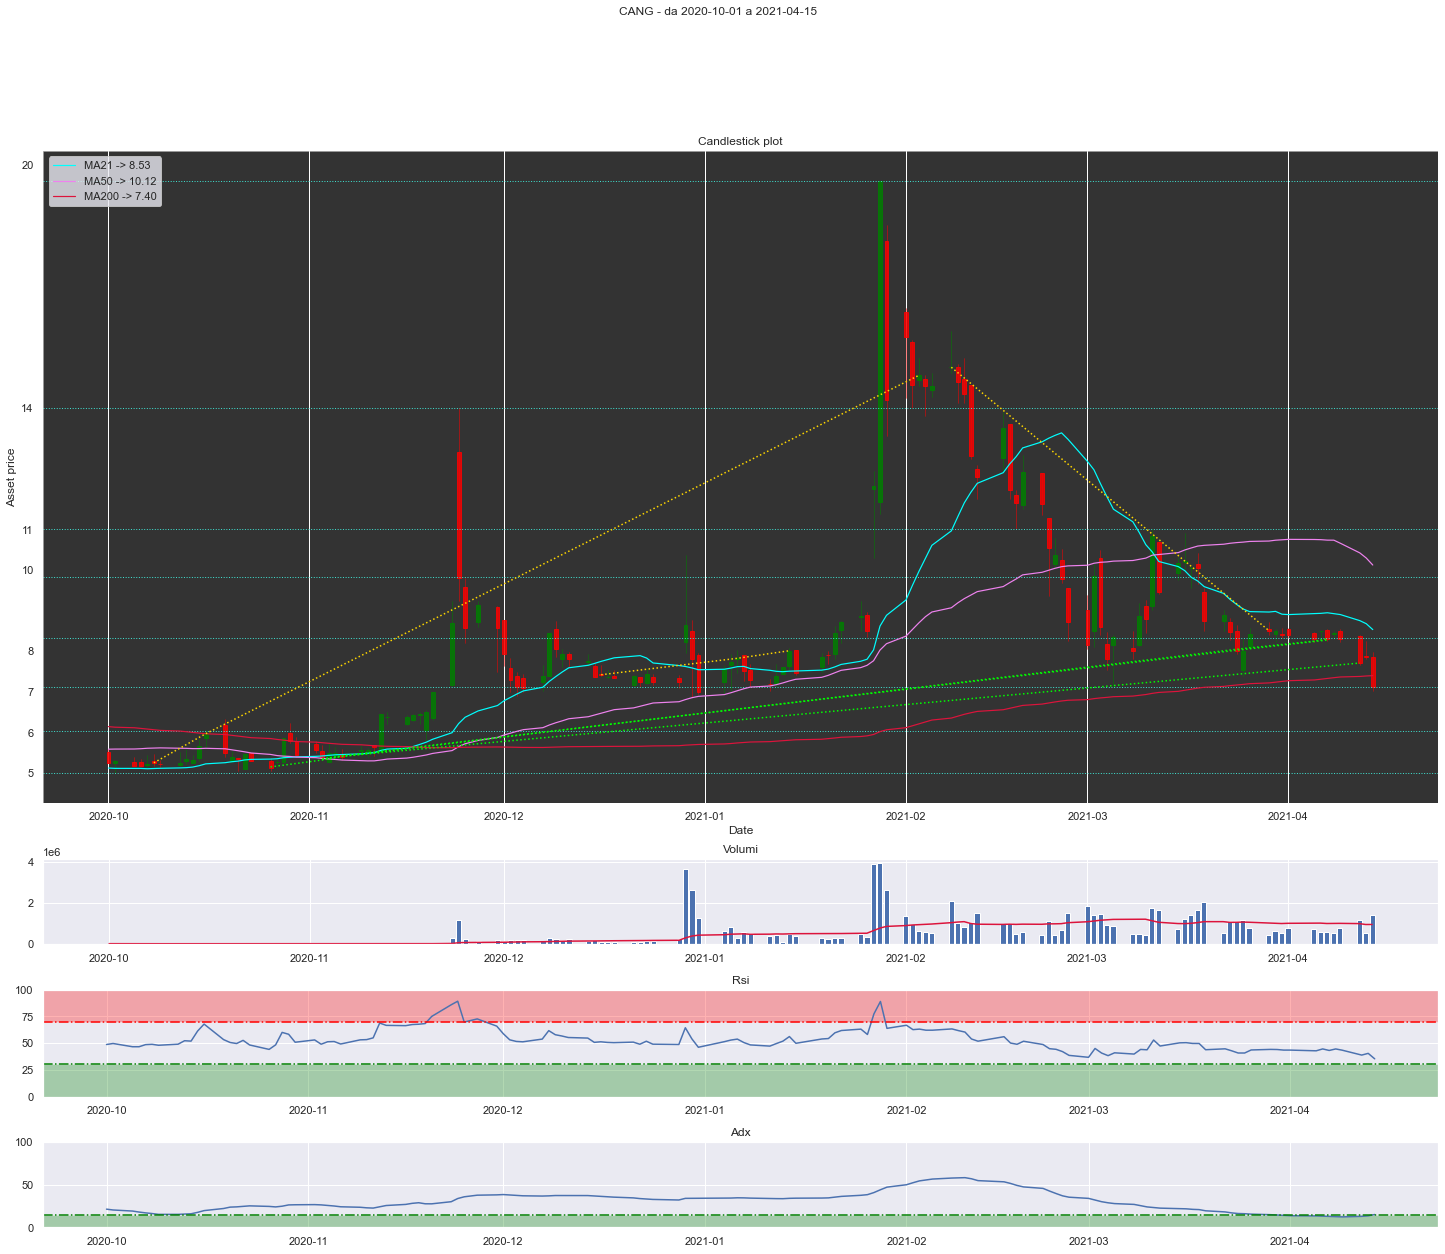

In [10]:
s =  np.mean(df['High'] - df['Low'])*2

# Ricavo i livelli di resistenza
levels = []
for i in range(2,df.shape[0]-2):
    if isSupport(df,i):
        l = df['Low'][i]

        if isFarFromLevel(l):
            levels.append((i,l))

    elif isResistance(df,i):
        l = df['High'][i]

        if isFarFromLevel(l):
            levels.append((i,l))

# Stampo il grafico e lo salvo su File
plot_all()